In [148]:
%reset -f 
# explore adaboost ensemble number of trees effect on performance
from numpy import mean
from numpy import std

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold,RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import roc_curve, auc


from matplotlib import pyplot
import pandas            as pd 
import numpy             as np 
import sklearn.tree      as skt 
import sklearn.metrics   as skm 
import matplotlib.pyplot as plt    


In [149]:
%matplotlib inline

In [150]:

n_qtl    = 3 
X_est = pd.read_csv( 'X_est.csv')  
Y_est = pd.read_csv( 'Y_est.csv')  
X_val = pd.read_csv( 'X_val.csv')  
# Y_val = pd.read_csv( 'Y_val.csv')  

In [151]:
X_est = X_est.set_index(['date'])
X_est.index = pd.to_datetime(X_est.index)
X_val = X_val.set_index(['date'])
X_val.index = pd.to_datetime(X_val.index)
Y_est = Y_est.set_index(['date'])
Y_est.index = pd.to_datetime(Y_est.index)

In [152]:
X_est.describe()

,V0_L1,V1_L1,V2_L1,V3_L1,V4_L1,V5_L1,V6_L1,V7_L1,V8_L1,V9_L1,...,V47_L12,V48_L12,V49_L12,V50_L12,V51_L12,V52_L12,V53_L12,V54_L12,V55_L12,V56_L12
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,...,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
mean,-0.000465,-0.000522,-0.002490,0.000546,0.001839,0.002297,-0.003256,0.000732,0.000455,-0.001394,...,0.000838,-0.008273,-0.006064,-0.008433,-0.004363,-0.003404,0.002864,-0.000789,0.008512,0.010236
std,0.057978,0.062699,0.050045,0.027100,0.036528,0.053244,0.049330,0.042985,0.042471,0.030654,...,0.004357,0.010599,0.013451,0.010236,0.013122,0.011223,0.010361,0.011942,0.017979,0.018315
min,-0.196882,-0.216018,-0.308951,-0.117529,-0.087577,-0.280505,-0.099747,-0.150711,-0.166877,-0.102246,...,-0.011051,-0.030455,-0.028005,-0.029909,-0.036568,-0.023463,-0.019800,-0.025682,-0.042453,-0.034211
25%,-0.033802,-0.037651,-0.022203,-0.013769,-0.019315,-0.018401,-0.038657,-0.027028,-0.023292,-0.019794,...,-0.002126,-0.014995,-0.012983,-0.014953,-0.012756,-0.009974,-0.003194,-0.009128,-0.005431,-0.005739
50%,-0.001897,-0.001587,-0.000745,-0.001236,-0.001631,0.003719,-0.007873,-0.001464,-0.000552,-0.001912,...,0.000746,-0.009613,-0.007170,-0.009620,-0.003598,-0.004560,0.002089,-0.002555,0.011158,0.012209
75%,0.027143,0.033427,0.020045,0.018238,0.016183,0.027985,0.021774,0.028304,0.023194,0.017229,...,0.004054,-0.003182,-0.003362,-0.003479,0.004494,-0.000290,0.005759,0.008316,0.018593,0.021598
max,0.226351,0.256999,0.164071,0.117917,0.189570,0.235309,0.254152,0.171878,0.149284,0.107992,...,0.009812,0.031211,0.059430,0.025086,0.029012,0.044689,0.043360,0.032979,0.051856,0.049328


In [153]:
Y_est.describe()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,...,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
mean,-0.001660,-0.002196,-0.002180,-0.000549,0.002182,0.001809,-0.005703,-0.000540,-0.001589,-0.003781,...,0.000068,-0.009020,-0.006610,-0.008972,-0.003924,-0.002865,0.002263,-0.000240,0.008028,0.009527
std,0.055834,0.061078,0.050234,0.027069,0.035817,0.051525,0.049765,0.043973,0.042931,0.032725,...,0.017895,0.036961,0.045364,0.034792,0.046484,0.041066,0.032952,0.036085,0.063827,0.062888
min,-0.196882,-0.216018,-0.308951,-0.117529,-0.087577,-0.280505,-0.099747,-0.150711,-0.166877,-0.102246,...,-0.077770,-0.124280,-0.131479,-0.118017,-0.106235,-0.101724,-0.113621,-0.082903,-0.236915,-0.232021
25%,-0.032960,-0.037769,-0.022203,-0.014468,-0.017402,-0.020568,-0.041154,-0.027351,-0.026332,-0.022336,...,-0.012376,-0.028582,-0.028298,-0.027128,-0.030789,-0.023186,-0.014838,-0.019258,-0.019453,-0.023526
50%,-0.000843,-0.001418,-0.001095,-0.001397,-0.000435,0.003390,-0.009407,0.000550,-0.001574,-0.003153,...,0.000035,-0.007502,-0.008675,-0.007321,-0.005974,-0.007102,0.004659,-0.001644,0.005769,0.011897
75%,0.024410,0.032460,0.023631,0.018464,0.017136,0.027409,0.019756,0.026141,0.022395,0.016410,...,0.010480,0.009860,0.010768,0.011176,0.019600,0.013538,0.018082,0.020700,0.042747,0.045807
max,0.226351,0.256999,0.164071,0.090732,0.189570,0.235309,0.254152,0.171878,0.149284,0.107992,...,0.046004,0.224556,0.301976,0.180529,0.233493,0.265748,0.181127,0.170255,0.242813,0.242865


In [154]:
X_val.describe()

,V0_L1,V1_L1,V2_L1,V3_L1,V4_L1,V5_L1,V6_L1,V7_L1,V8_L1,V9_L1,...,V47_L12,V48_L12,V49_L12,V50_L12,V51_L12,V52_L12,V53_L12,V54_L12,V55_L12,V56_L12
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,...,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,-0.006637,-0.007479,-0.008018,-0.004823,0.004412,0.001484,-0.016957,-0.005204,-0.009427,-0.014340,...,0.000662,-0.006292,-0.002661,-0.006010,-0.006020,-0.001158,0.007819,-0.000257,0.010504,0.013032
std,0.049349,0.055590,0.032215,0.029657,0.034365,0.036521,0.038405,0.041209,0.038894,0.034662,...,0.003511,0.012324,0.018089,0.011765,0.014569,0.014866,0.012026,0.013069,0.018562,0.019219
min,-0.137193,-0.121787,-0.106646,-0.076545,-0.084585,-0.110452,-0.083407,-0.106177,-0.106316,-0.095947,...,-0.006581,-0.021777,-0.024619,-0.018564,-0.030143,-0.020927,-0.007716,-0.018712,-0.025200,-0.018483
25%,-0.027168,-0.024497,-0.023906,-0.019936,-0.006293,-0.012714,-0.043337,-0.017141,-0.028794,-0.035267,...,-0.000718,-0.014780,-0.014714,-0.013571,-0.016930,-0.011046,0.001689,-0.012193,-0.002513,-0.000722
50%,0.003767,0.000923,-0.005783,-0.000408,0.013046,0.003880,-0.018148,0.006856,-0.001574,-0.016830,...,0.000205,-0.010577,-0.006519,-0.011137,-0.006307,-0.001856,0.003628,-0.002298,0.010792,0.016829
75%,0.021710,0.034575,0.008206,0.014600,0.026446,0.023018,0.008701,0.013997,0.018654,0.004708,...,0.003615,-0.001852,-0.002233,-0.002164,0.006153,0.002103,0.009406,0.008589,0.023775,0.025531
max,0.061401,0.076982,0.048108,0.058589,0.071272,0.079767,0.102382,0.070568,0.042293,0.080208,...,0.005927,0.025082,0.045158,0.026028,0.023280,0.035086,0.043158,0.029757,0.056326,0.053583


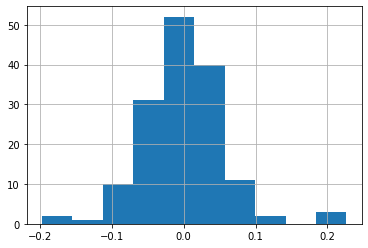

In [155]:
X_est['V0_L1'].hist()

In [156]:
# evaluate a given model using cross-validation
def get_x_cols(y_col,all_x_cols):
    return [i for i in all_x_cols if y_col in i]
Y_val = pd.DataFrame()
grid = dict()
grid['n_estimators'] = [1,2,3,4,5,10]
grid['learning_rate'] = [0.0001, 0.1, 1.0]
grid['subsample'] = [0.5, 0.7, 1.0]
grid['max_depth'] = [3,4,5]
grid['max_features'] = [None,'auto','log2']
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

results, names = list(), list()
for y_col in Y_est.columns:
    model = GradientBoostingRegressor()
    x_cols = get_x_cols(y_col,X_est.columns)
    cv = RepeatedKFold(n_splits=2, n_repeats=3, random_state=1)
    # define the grid search procedure
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_mean_absolute_error')
    # execute the grid search
    grid_result = grid_search.fit(X_est[x_cols], Y_est[y_col])
    best_params = grid_result.best_params_
    # summarize the best score and configuration
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    # summarize all scores that were evaluated
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    #for mean, stdev, param in zip(means, stds, params):
    #    print("%f (%f) with: %r" % (mean, stdev, param))
#     
#     scores = evaluate_model(model, X_est, Y_est[y_col])
#     # fit the model on the whole dataset
    model = GradientBoostingRegressor(**best_params)
    model.fit(X_est[x_cols], Y_est[y_col])
#     results.append(scores)
#     names.append(y_col)
#     # summarize the performance along the way
#     print('>%s %.3f (%.3f)' % (y_col, mean(scores), std(scores)))
#     # make a single prediction
# #     row = [[1.20871625,0.88440466,-0.9030013,-0.22687731,-0.82940077,-1.14410988,1.26554256,-0.2842871,1.43929072,0.74250241,0.34035501,0.45363034,0.1778756,-1.75252881,-1.33337384,-1.50337215,-0.45099008,0.46160133,0.58385557,-1.79936198]]
    Y_val[y_col] = model.predict(X_val[x_cols])

#     print('Prediction: ' , Y_val[y_col])

Best: -0.040500 using {'learning_rate': 0.1, 'max_depth': 4, 'max_features': None, 'n_estimators': 5, 'subsample': 0.7}
Best: -0.045279 using {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 1, 'subsample': 0.5}
Best: -0.031771 using {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 3, 'subsample': 1.0}
Best: -0.020395 using {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 1, 'subsample': 0.7}
Best: -0.025246 using {'learning_rate': 0.0001, 'max_depth': 5, 'max_features': None, 'n_estimators': 5, 'subsample': 0.5}
Best: -0.034289 using {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 2, 'subsample': 0.7}
Best: -0.037131 using {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'log2', 'n_estimators': 1, 'subsample': 0.5}
Best: -0.033440 using {'learning_rate': 0.0001, 'max_depth': 4, 'max_features': None, 'n_estimators': 10, 'subsample': 0.5}
Best: -0.032484 using {

In [157]:
Y_val.index = X_val.index
Y_val.to_csv("Y_val_gradient_boosting.csv")

In [158]:
Y_val

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56
date,,,,,,,,,,,,,,,,,,,,,
2018-02-28,0.000017,-0.002163,-0.001037,0.001145,0.002179,0.002400,-0.005625,-0.000537,-0.004027,-0.004201,...,0.000260,-0.010478,-0.007785,-0.009291,-0.002638,-0.003964,0.000557,-0.001660,0.006020,0.010209
2007-04-30,0.002724,-0.002163,-0.001037,-0.001386,0.002182,0.002400,-0.005625,-0.000541,-0.001121,-0.004201,...,0.000260,-0.009188,-0.007785,-0.009291,-0.004967,-0.003964,0.001525,0.008440,0.008479,0.010209
2011-08-31,-0.002904,-0.002163,-0.001037,-0.001386,0.002187,0.002400,0.001647,-0.000580,-0.001762,-0.004201,...,0.000260,-0.015732,-0.008746,-0.009291,-0.009057,-0.002866,-0.004813,-0.009000,0.018262,0.009895
2007-02-28,-0.004437,-0.002163,-0.001037,-0.001386,0.002180,0.002400,-0.005625,-0.000541,-0.004027,-0.004201,...,0.000260,-0.009188,-0.007785,-0.009291,-0.002638,-0.002866,0.001525,-0.002846,0.008479,0.010209
2016-01-29,-0.002904,-0.002163,-0.001037,-0.001386,0.002185,0.002400,-0.009399,-0.000564,-0.001762,-0.004201,...,0.000260,-0.009188,-0.005806,-0.009291,-0.001300,-0.001696,0.002561,-0.000427,0.011854,0.020530
2019-04-30,-0.002027,-0.002163,-0.001037,0.005899,0.002184,0.002400,-0.005625,-0.000541,-0.006154,-0.004201,...,0.000260,-0.007511,-0.007785,-0.009291,-0.004967,-0.002866,0.000557,-0.002846,0.012815,0.020530
2013-07-31,0.000017,-0.002163,-0.001037,-0.000009,0.002182,0.002400,-0.005625,-0.000518,-0.001762,-0.004201,...,0.000260,-0.013029,-0.008746,-0.009291,0.003305,-0.001696,0.002192,0.014998,0.008479,0.010209
2011-05-31,-0.006633,-0.002163,-0.001037,-0.001386,0.002180,0.002400,-0.000383,-0.000540,-0.004027,-0.004201,...,0.000260,-0.009188,-0.007785,-0.009291,-0.004967,-0.002866,0.002561,-0.000720,0.011854,0.020530
2016-08-31,-0.003263,-0.002163,-0.001037,-0.000009,0.002182,0.002400,-0.005625,-0.000550,-0.001762,-0.004201,...,0.000260,-0.015732,-0.011719,-0.009291,-0.004498,-0.008802,0.003678,-0.005780,-0.009723,0.020530
